In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
from implementations import *
DATA_TRAIN_PATH = 'data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
DATA_TEST_PATH = 'data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
def map_label_01(y):
    y_logistic = []
    for elem in y:
        if elem == -1:
            y_logistic.append(0)
        else:
            y_logistic.append(1)
            
    return np.asarray(y_logistic)

In [5]:
def cross_validation_least_squares_GD(y, tx, initial_w, max_iters, gammas, k_fold, seed):
    """Do cross-validation to find the best gamma to use with least_squares_GD"""
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    mse_tr = []
    mse_te = []
    
    weights = initial_w
    
    for gamma in gammas:
        tr_tmp = []
        te_tmp = []
        for k in range(k_fold):
            # divide the data into training set and testing set depending on k
            tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
            test_tx = tx[k_indices[k]]
            test_y = y[k_indices[k]]
            train_tx = tx[tr_indice]
            train_y = y[tr_indice]
            
            #Train the set and computes the losses
            weights, loss_tr = least_squares_GD(train_y, train_tx, initial_w, max_iters, gamma)
            loss_te = compute_loss(mse, test_y, test_tx, weights)
            
            tr_tmp.append(loss_tr)
            te_tmp.append(loss_te)
        mse_tr.append(np.mean(tr_tmp))
        mse_te.append(np.mean(te_tmp))

    gamma = gammas[np.argmin(mse_te)]
    weights_final, loss = least_squares_GD(y, tx, initial_w, max_iters, gamma)
        
    return mse_tr, mse_te, gamma, weights_final, loss

In [10]:
def cross_validation_logistic_regression(y, tx, initial_w, max_iters, gammas, k_fold, seed):
    """Do cross-validation to find the best gamma to use with logistic regression"""
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    loss_sigmoid_tr = []
    loss_sigmoid_te = []
    
    weights = initial_w
    
    for gamma in gammas:
        tr_tmp = []
        te_tmp = []
        for k in range(k_fold):
            # divide the data into training set and testing set depending on k
            tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
            test_tx = tx[k_indices[k]]
            test_y = y[k_indices[k]]
            train_tx = tx[tr_indice]
            train_y = y[tr_indice]
            
            #Train the set and computes the losses
            weights, loss_tr = logistic_regression(train_y, train_tx, initial_w, max_iters, gamma)
            loss_te = calculate_loss_sigmoid(test_y, test_tx, weights)
            
            tr_tmp.append(loss_tr)
            te_tmp.append(loss_te)
        loss_sigmoid_tr.append(np.mean(tr_tmp))
        loss_sigmoid_te.append(np.mean(te_tmp))
        
    gamma = gammas[np.argmin(loss_sigmoid_te)]
    weights_final, loss_sigmoid = logistic_regression(y, tx, initial_w, max_iters, gamma)
        
    return loss_sigmoid_tr, loss_sigmoid_te, gamma, weights_final, loss_sigmoid

In [ ]:
#least_squares_GD cross-validation
max_iters = 200
k_fold = 5
seed = 42

tX_stdrzed, mean, std = standardize(tX)

initial_w = np.array([0.4 for i in range(tX_stdrzed.shape[1])])

gammas_lsgd = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])
mse_tr_least_squares_GD, mse_te_least_squares_GD, gamma, weights, loss = \
    cross_validation_least_squares_GD(y, tX_stdrzed, initial_w, max_iters, gammas_lsgd, k_fold, seed)

print(mse_tr_least_squares_GD)
print(mse_te_least_squares_GD)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd = (tX_test-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd)
OUTPUT_PATH = 'data/output_least_squares_GD.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#0.697 on AICrowd initial_w = np.array([0.4 for i in range(tX_stdrzed.shape[1])]) 
#0.693 on AICrowd initial_w = np.array([0.0 for i in range(tX_stdrzed.shape[1])]) even if loss smaller

In [13]:
#logistic_regression cross-validation
max_iters = 1000
k_fold = 5
seed = 42

tX_stdrzed, mean, std = standardize(tX)
y_logistic = map_label_01(y)
        
initial_w = np.array([0.5 for i in range(tX_stdrzed.shape[1])])
gammas_logistic = np.array([0.00000001, 0.0000001, 0.0000005, 0.000001, 0.000005])

losses_tr_logistic_regression, losses_te_logistic_regression, gamma, weights, loss = \
    cross_validation_logistic_regression(y_logistic, tX_stdrzed, initial_w, max_iters, gammas_logistic, k_fold, seed)

print(losses_tr_logistic_regression)
print(losses_te_logistic_regression)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd = (tX_test-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd)
OUTPUT_PATH = 'data/output_logistic_regression.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#0.739 on AICrowd

[37652.404918522974]
[37652.404918522974, 29027.774020060468]
[37652.404918522974, 29027.774020060468, 27764.098075652997]
[37652.404918522974, 29027.774020060468, 27764.098075652997, 26830.30497283832]
[37652.404918522974, 29027.774020060468, 27764.098075652997, 26830.30497283832, 40424.460016898876]
[150475.07846440357, 116091.83349352962, 111050.11129959478, 107321.8588723096, 175048.16703055985]
[37652.404918522974, 29027.774020060468, 27764.098075652997, 26830.30497283832, 40424.460016898876]
1e-06
[  0.36107142 -13.33658378  -1.35496582   0.61783235   0.01961971
   1.04982336  -0.11726647   0.89216496  -0.57865051   2.93050219
   0.07234096   1.13344787   0.04818739  10.01062522   0.50332153
   0.46376109  -0.86057156   0.49976145   0.56555557   2.7359336
   0.54131802  -0.85535579   0.43301581  -0.12296951   0.11121371
   0.12505995  -0.93148483  -0.03097258  -0.05234122  -5.18514794]
132212.66176250146


In [22]:
#least_squares_GD cross-validation with cleaned data
max_iters = 200
k_fold = 5
seed = 42

tX_stdrzed_cleaned, mean, std = standardize(remove_wrong_columns(tX))

initial_w = np.array([0.4 for i in range(tX_stdrzed_cleaned.shape[1])]) 
gammas_lsgd_clean = np.array([0.01, 0.05, 0.1, 0.11, 0.12, 0.128])

mse_tr_least_squares_GD_clean, mse_te_least_squares_GD_clean, gamma, weights, loss = \
    cross_validation_least_squares_GD(y, tX_stdrzed_cleaned, initial_w, max_iters, gammas_lsgd_clean, k_fold, seed)

print(mse_tr_least_squares_GD_clean)
print(mse_te_least_squares_GD_clean)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd_cleaned = (remove_wrong_columns(tX_test)-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd_cleaned)
OUTPUT_PATH = 'data/output_least_squares_GD_clean.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#0.72 on AICrowd

[0.4829444274069787, 0.3785810578920398, 0.37585500287088003, 0.37569930267400325, 0.37556759611875135, 0.6061135886916136]
[0.4823999202585222, 0.37856564679284066, 0.37588735835461606, 0.37573361444383624, 0.37560345237880965, 0.6036864256436408]
0.12
[-0.67353872 -0.01935749  0.08089317  0.10270136 -0.09230546  0.14814314
  0.05376114  0.10372283  0.42233461  0.06302186  0.06079259  0.012026
  0.0630258   0.06600923  0.06210411  0.06446594 -0.03588135  0.07445922
 -0.15745303]
0.37557229648318674


In [28]:
#logistic_regression cross-validation with cleaned data
max_iters = 1000
k_fold = 5
seed = 42

tX_stdrzed_cleaned, mean, std = standardize(remove_wrong_columns(tX))
y_logistic = map_label_01(y)
        
initial_w = np.array([0.5 for i in range(tX_stdrzed_cleaned.shape[1])])
gammas_logistic_clean = np.array([0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001])

losses_tr_logistic_regression_clean, losses_te_logistic_regression_clean, gamma, weights, loss = \
    cross_validation_logistic_regression(y_logistic, tX_stdrzed_cleaned,\
                                         initial_w, max_iters, gammas_logistic_clean, k_fold, seed)

print(losses_tr_logistic_regression_clean)
print(losses_te_logistic_regression_clean)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd_cleaned = (remove_wrong_columns(tX_test)-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd_cleaned)
OUTPUT_PATH = 'data/output_logistic_regression_clean.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

[nan]
[nan, 27711.668125686665]
[nan, 27711.668125686665, 27440.823026442493]


KeyboardInterrupt: 

# Graphs

In [26]:
def make_plots_gammas(te_losses, gammas, save_name, title):
    plt.semilogx(gammas, te_losses, marker=".", color='b', label='cross-validation test error')
    plt.xlabel("gamma")
    plt.ylabel("error")
    plt.title(title)
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig(save_name)

In [ ]:
#Least squares
make_plots_gammas(mse_te_least_squares_GD, gammas_lsgd, \
                  "raw_data_least_squares_GD", "Least squares gradient descent raw data")

In [ ]:
#Least squares without disturbing gamma
make_plots_gammas(mse_te_least_squares_GD[:-1], gammas_lsgd[:-1], \
                  "raw_data_least_squares_GD_useful", "Useful gammas for least squares gradient descent raw data")

In [ ]:
#Logistic regression
make_plots_gammas(losses_te_logistic_regression, gammas_logistic, \
                  "raw_data_logistic_regression", "Logistic regression raw data")

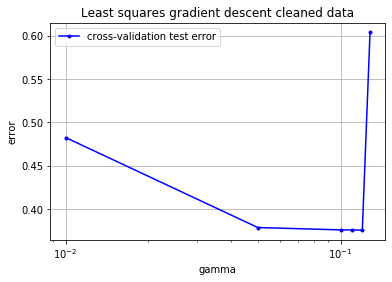

In [27]:
#Least squares with cleaned data
make_plots_gammas(mse_te_least_squares_GD_clean, gammas_lsgd_clean, \
                  "raw_data_least_squares_GD_clean", "Least squares gradient descent cleaned data")

In [ ]:
#Logistic regression with cleaned data
make_plots_gammas(losses_tr_logistic_regression_clean, losses_te_logistic_regression_clean, gammas_logistic_clean, \
                  "raw_data_logistic_regression_clean", "Logistic regression cleaned data")